<a href="https://colab.research.google.com/github/ItsAdel/binaryimageclassifier/blob/main/Binary_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "itsadel"
os.environ['KAGGLE_KEY'] = "e57c4f0bf85924ec4cf2166f5a9162fd"
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset

100% 11.1G/11.1G [04:29<00:00, 33.5MB/s]
100% 11.1G/11.1G [04:29<00:00, 44.3MB/s]


In [ ]:
from zipfile import ZipFile

file_name = "/content/arthropod-taxonomy-orders-object-detection-dataset.zip"

with ZipFile(file_name, 'r') as zipp:
  zipp.extractall()
  print('done')

done


In [ ]:

data_dir_list = os.listdir('/content/ArTaxOr/Araneae')
#print(data_dir_list)

path, dirs, files = next(os.walk("/content/ArTaxOr/Coleoptera"))
file_count = len(files)
print(file_count)

2110


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [ ]:
BASE_PATH = '/content/ArTaxOr'
# need to remove these files before deleting rest of the directories
os.remove(BASE_PATH+'/ArTaxOr.png')
os.remove(BASE_PATH+'/license.txt')
os.remove(BASE_PATH+'/readme.txt')
os.remove(BASE_PATH+'/revision history.txt')

In [ ]:
image=[]
labels=[]

for file in os.listdir(BASE_PATH):
    if file=='Araneae':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Araneae')
    elif file=='Coleoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Coleoptera')
    else:
        # remove unused directories
        shutil.rmtree(os.path.join(BASE_PATH, file))
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

Images   labels
0  d2f5e9128fe1.jpg  Araneae
1  657b325c337b.jpg  Araneae
2  a81e55548015.jpg  Araneae
3  dc2760280a89.jpg  Araneae
4  4a7999cd5e71.jpg  Araneae

In [ ]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

Images   labels  encoded_labels
0  d2f5e9128fe1.jpg  Araneae               0
1  657b325c337b.jpg  Araneae               0
2  a81e55548015.jpg  Araneae               0
3  dc2760280a89.jpg  Araneae               0
4  4a7999cd5e71.jpg  Araneae               0

In [ ]:
dataset_size = len(data)
print(dataset_size)

4528


In [ ]:
# https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
train, validate, test = np.split(data.sample(frac=1, random_state=10), [int(.6*len(data)), int(.8*len(data))])

train_indices = list(train.index)
val_indices = list(validate.index)
test_indices = list(test.index)


In [ ]:
print(len(train))
print(len(validate))
print(len(test))
print(test_indices)

2716
906
906
[4310, 2010, 3779, 3576, 3572, 1311, 1359, 3688, 1007, 416, 1321, 3682, 2217, 1016, 1273, 2799, 4096, 4062, 111, 1915, 2492, 919, 4473, 1535, 3334, 3717, 2841, 3845, 240, 3578, 4022, 3060, 1312, 3551, 2340, 3054, 1550, 645, 2638, 4106, 1259, 1689, 4172, 2284, 399, 3167, 2332, 4448, 1465, 1833, 554, 1700, 3564, 2203, 1083, 4005, 2525, 198, 3955, 2735, 2455, 1125, 215, 748, 150, 3027, 2188, 2043, 3255, 2951, 2958, 1606, 759, 987, 2458, 4450, 2350, 2301, 1714, 2297, 4444, 4265, 4520, 4278, 2441, 3876, 4341, 3006, 88, 3314, 3080, 4419, 910, 3037, 782, 1373, 1537, 2015, 1140, 250, 2147, 585, 4163, 488, 1477, 1759, 4281, 1410, 1811, 1078, 3683, 1086, 1034, 3348, 2241, 2563, 293, 504, 4115, 4237, 2164, 434, 4210, 443, 1069, 1735, 2793, 526, 3309, 4381, 3399, 206, 1439, 53, 3635, 3414, 2180, 3449, 2405, 1860, 682, 3824, 1332, 3267, 2921, 3550, 4492, 3695, 3056, 2731, 4274, 141, 508, 2953, 1015, 3652, 3091, 3907, 2678, 3219, 1262, 3990, 1498, 2956, 3728, 2105, 2333, 405, 1221, 884,

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# Custom dataset example from https://github.com/utkuozbulak/pytorch-custom-dataset-examples

class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
dataset = Arthopod_Dataset(data,BASE_PATH,transform)

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg



# Visualization


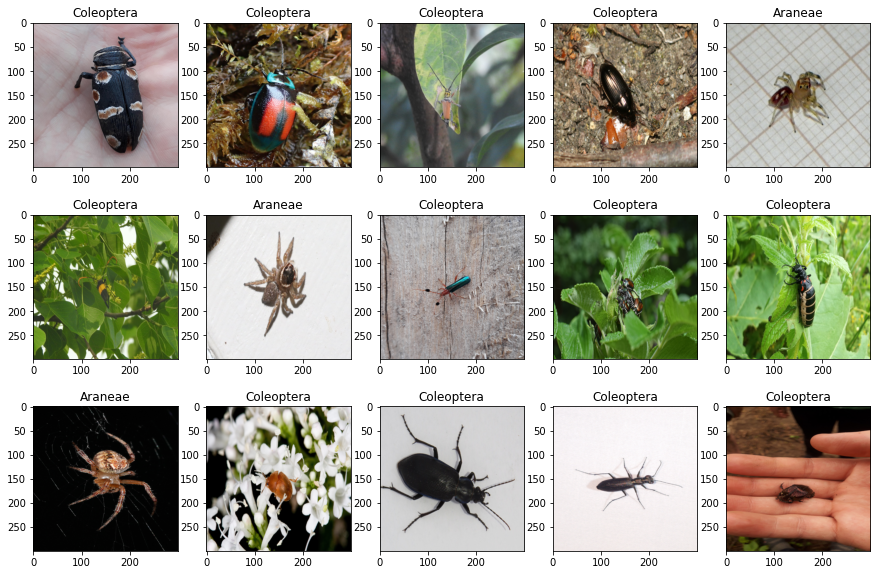

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Araneae', 1: 'Coleoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}")

# Training data

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:

#model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/12], Step [0/22], Loss: 0.6987
Epoch [1/12], Step [20/22], Loss: 0.7067

train loss: 0.6944, train acc: 53.5714
validation loss: 0.6892, validation acc: 51.6556

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/22], Loss: 0.6633
Epoch [2/12], Step [20/22], Loss: 0.6934

train loss: 0.6873, train acc: 56.5906
validation loss: 0.6923, validation acc: 51.5453

Epoch 3

Epoch [3/12], Step [0/22], Loss: 0.6651
Epoch [3/12], Step [20/22], Loss: 0.6738

train loss: 0.6774, train acc: 61.5243
validation loss: 0.6929, validation acc: 52.0971

Epoch 4

Epoch [4/12], Step [0/22], Loss: 0.6506
Epoch [4/12], Step [20/22], Loss: 0.6276

train loss: 0.6710, train acc: 62.9602
validation loss: 0.6878, validation acc: 55.1876

Detected network improvement, saving current model
Epoch 5

Epoch [5/12], Step [0/22], Loss: 0.6776
Epoch [5/12], Step [20/22], Loss: 0.6524

train loss: 0.6630, train acc: 64.6907
validation loss: 0.6837, validation acc: 56.9536

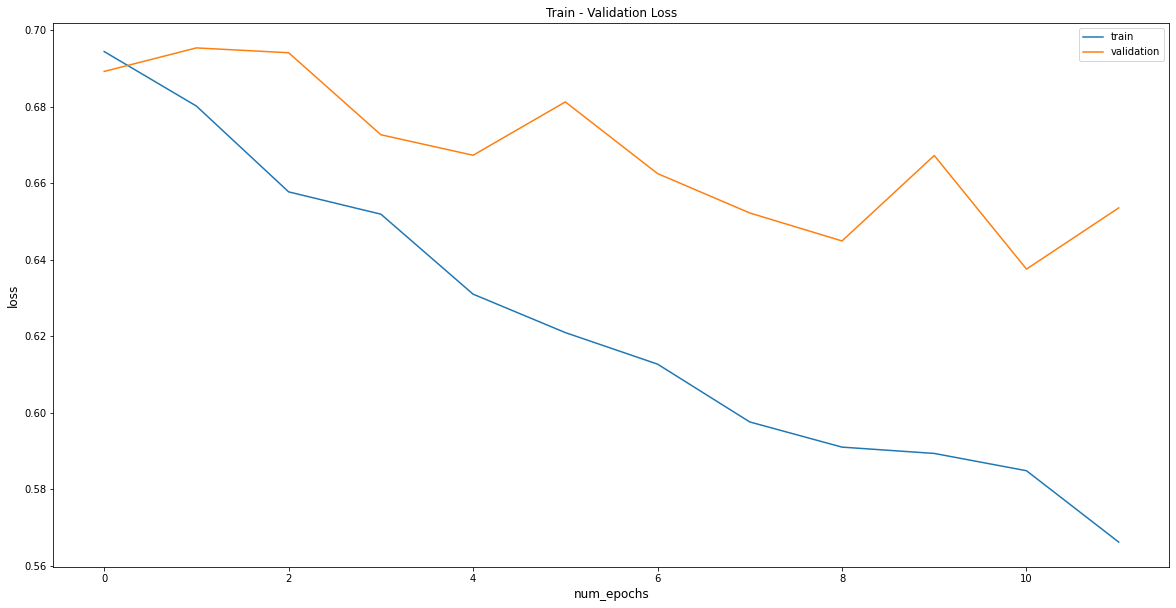

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

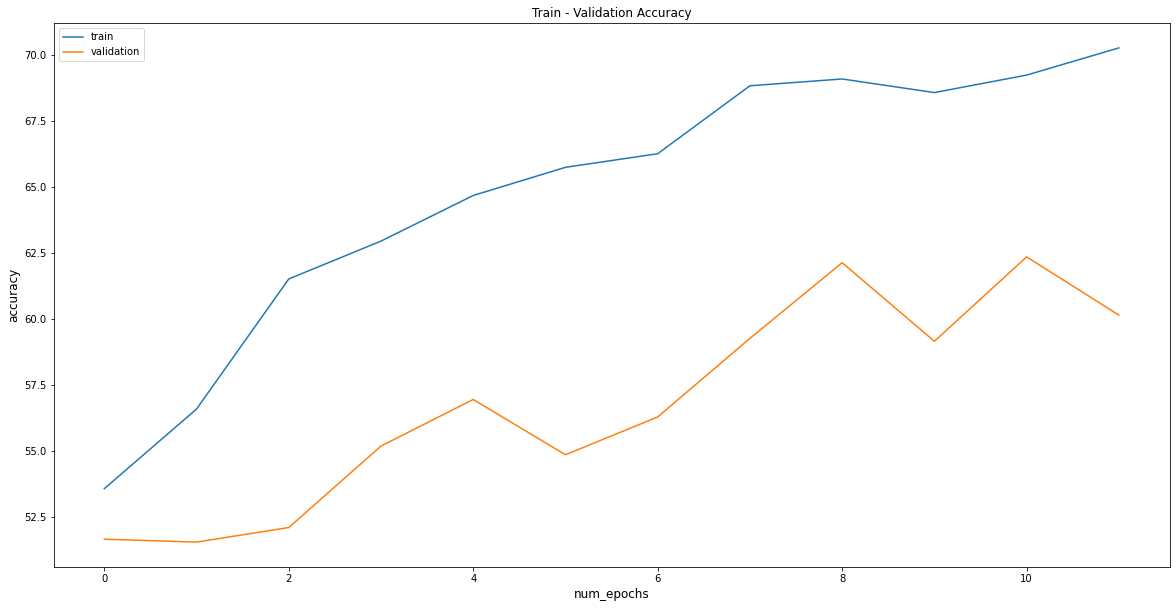

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

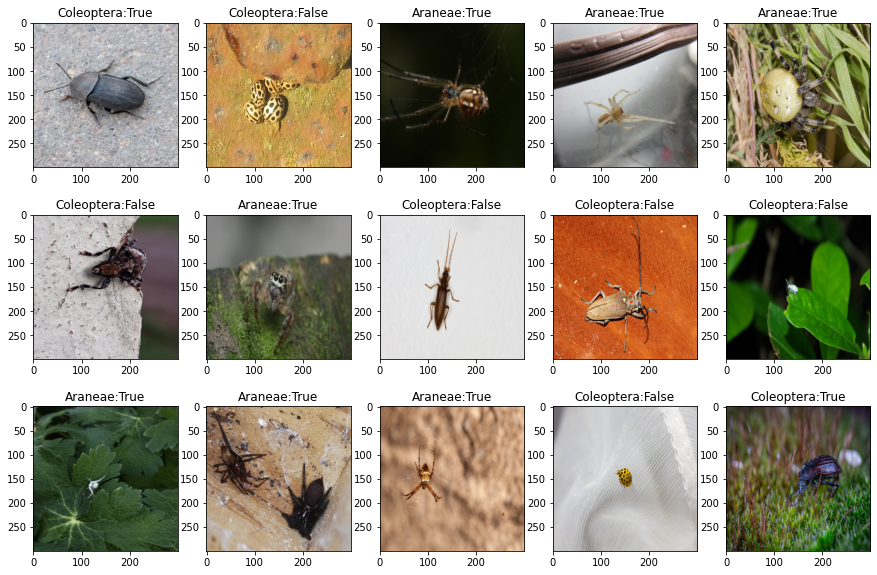

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Araneae', 1: 'Coleoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat, images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).to(device)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 65.45253863134658 %


# Apply Image augmentation

In [ ]:
transform = transforms.Compose(
    [transforms.RandomRotation(degrees=45),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomGrayscale(p=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
dataset = Arthopod_Dataset(data,BASE_PATH,transform)

In [ ]:
batch_size = 254

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

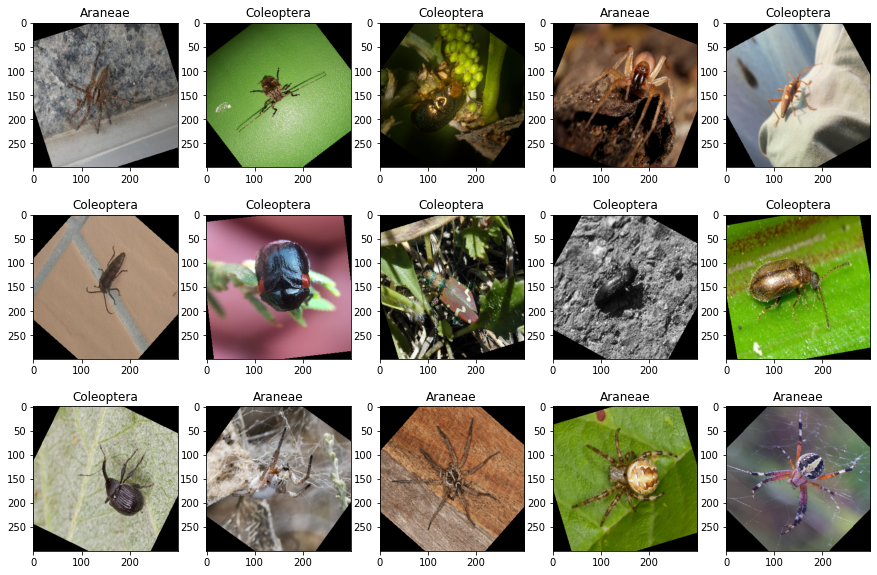

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Araneae', 1: 'Coleoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}")

In [ ]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/12], Step [0/11], Loss: 0.6344

train loss: 0.6302, train acc: 67.1208
validation loss: 0.6427, validation acc: 63.2450

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/11], Loss: 0.6171

train loss: 0.6354, train acc: 64.2857
validation loss: 0.6454, validation acc: 62.8035

Epoch 3

Epoch [3/12], Step [0/11], Loss: 0.6497

train loss: 0.6318, train acc: 64.9485
validation loss: 0.6483, validation acc: 62.8035

Epoch 4

Epoch [4/12], Step [0/11], Loss: 0.5984

train loss: 0.6280, train acc: 66.4948
validation loss: 0.6494, validation acc: 64.1280

Epoch 5

Epoch [5/12], Step [0/11], Loss: 0.5819

train loss: 0.6274, train acc: 66.1267
validation loss: 0.6498, validation acc: 62.9139

Epoch 6

Epoch [6/12], Step [0/11], Loss: 0.6395

train loss: 0.6263, train acc: 66.6053
validation loss: 0.6504, validation acc: 63.0243

Epoch 7

Epoch [7/12], Step [0/11], Loss: 0.6069

train loss: 0.6259, train acc: 65.2062
validation loss: 0.6504, v

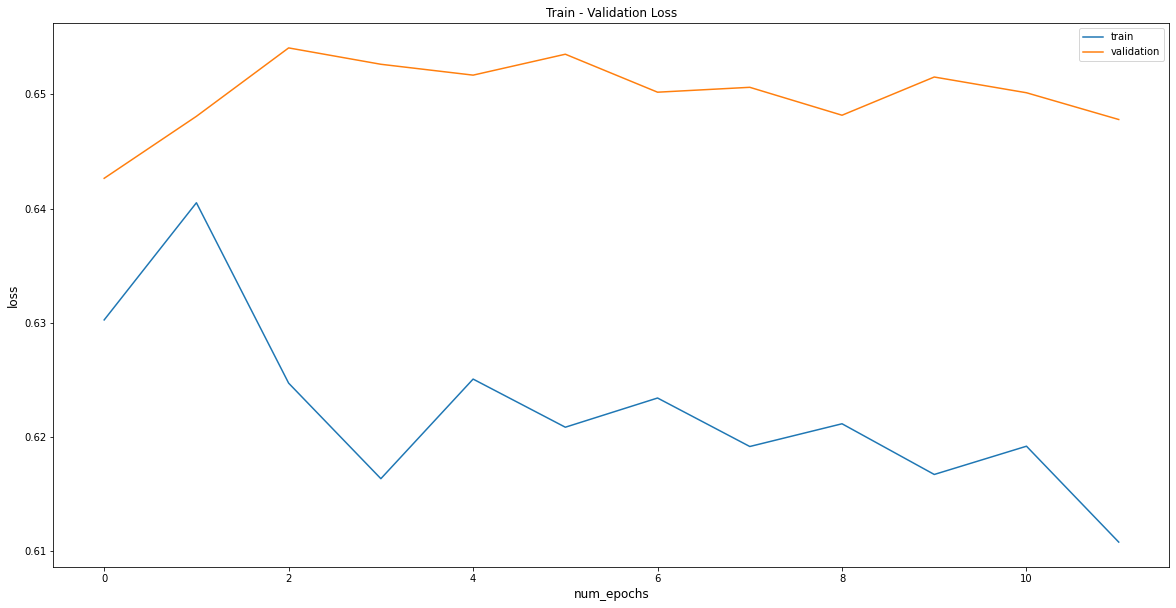

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

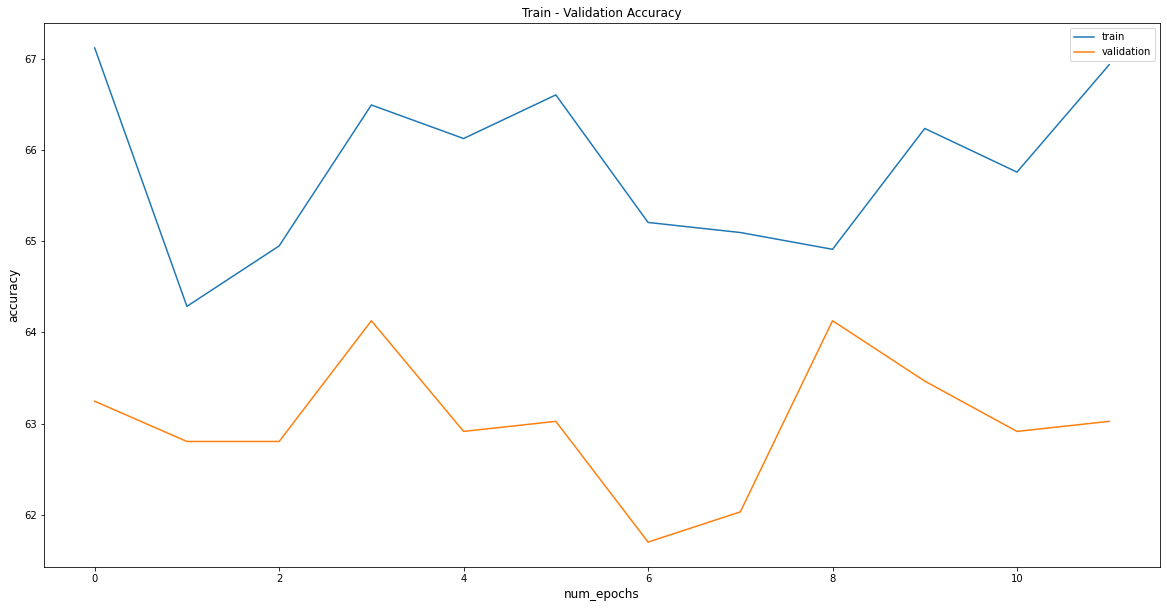

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

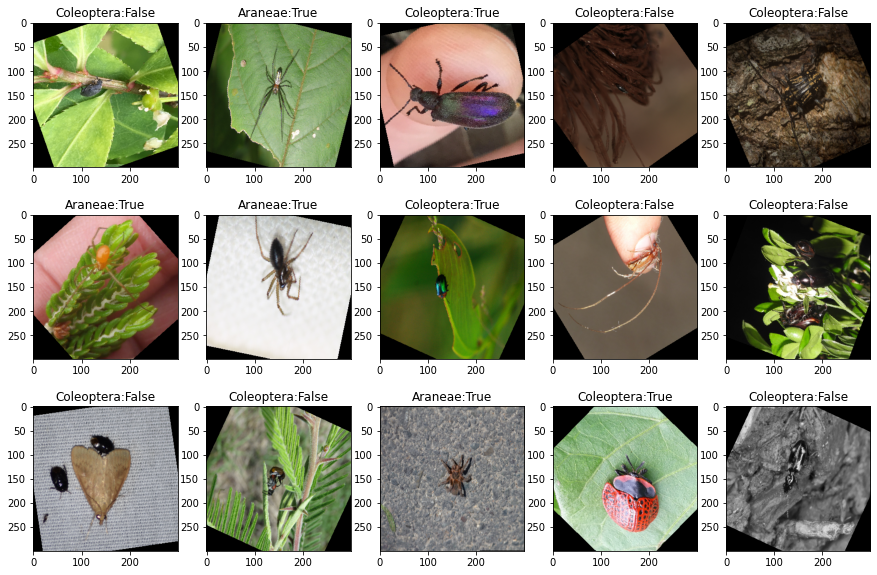

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Araneae', 1: 'Coleoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat, images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).to(device)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 65.78366445916114 %


### Pretrained model

In [ ]:
from torchvision import models

In [ ]:
res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
res_mod = res_mod.to(device)

In [ ]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = res_mod(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        res_mod.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = res_mod(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(res_mod.state_dict(), 'res_model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    res_mod.train()

Epoch 1

Epoch [1/12], Step [0/22], Loss: 0.8321
Epoch [1/12], Step [20/22], Loss: 0.7800

train loss: 0.7919, train acc: 43.5935
validation loss: 0.7710, validation acc: 42.8256

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/22], Loss: 0.8190
Epoch [2/12], Step [20/22], Loss: 0.8056

train loss: 0.7938, train acc: 43.6303
validation loss: 0.7720, validation acc: 46.6887

Epoch 3

Epoch [3/12], Step [0/22], Loss: 0.7687
Epoch [3/12], Step [20/22], Loss: 0.7905

train loss: 0.7933, train acc: 43.2253
validation loss: 0.7687, validation acc: 46.6887

Detected network improvement, saving current model
Epoch 4

Epoch [4/12], Step [0/22], Loss: 0.7893
Epoch [4/12], Step [20/22], Loss: 0.7609

train loss: 0.7918, train acc: 43.7408
validation loss: 0.7684, validation acc: 45.5850

Epoch 5

Epoch [5/12], Step [0/22], Loss: 0.7869
Epoch [5/12], Step [20/22], Loss: 0.8170

train loss: 0.7918, train acc: 42.7467
validation loss: 0.7701, validation acc: 45.3642

In [ ]:
res_mod.load_state_dict(torch.load('res_model_classification_tutorial.pt'))

<All keys matched successfully>

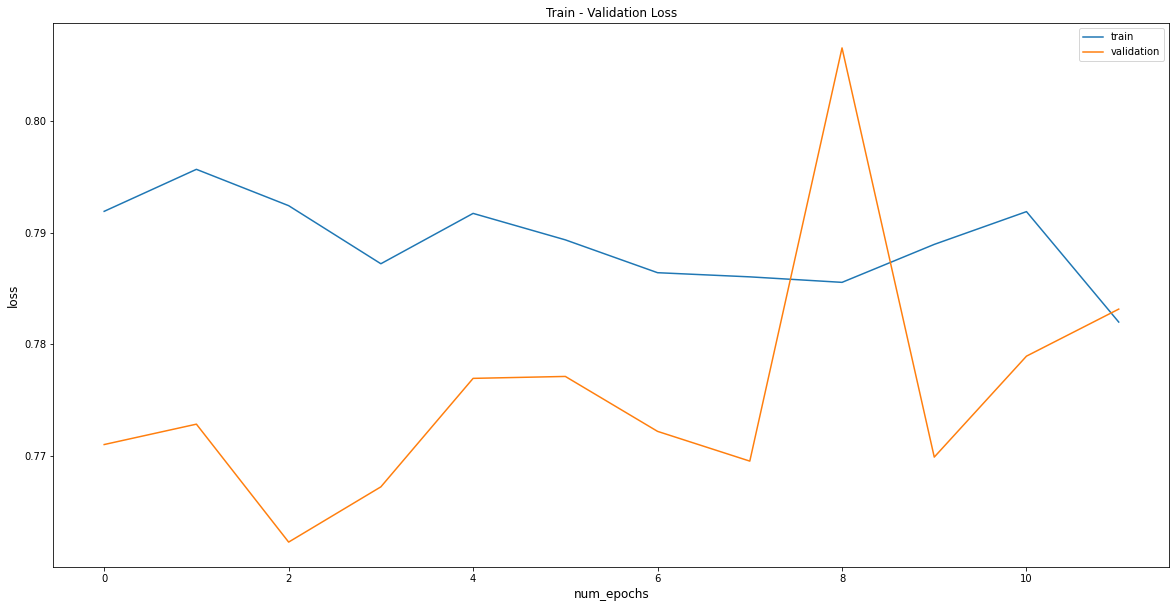

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

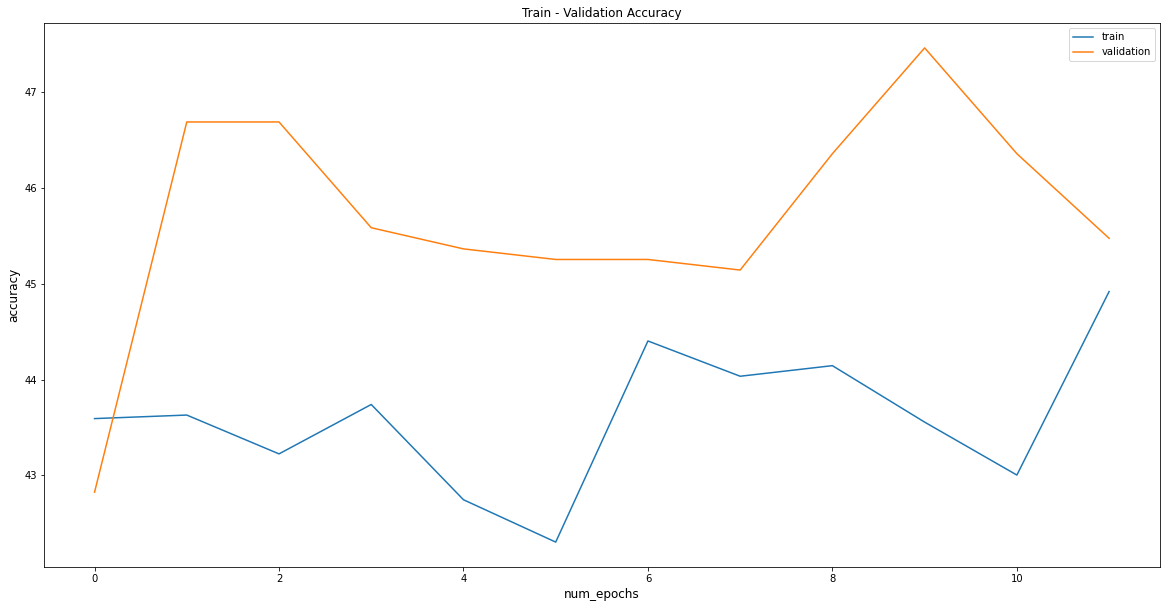

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

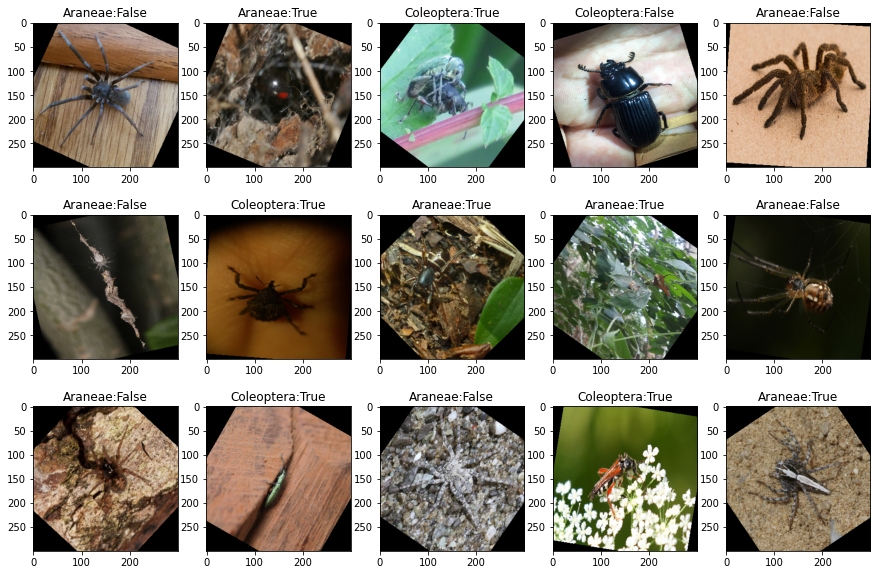

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Araneae', 1: 'Coleoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    res_mod.eval()
    for ax, image, label in zip(axis.flat, images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).to(device)
        output_ = res_mod(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label

In [ ]:
# Test the res_mod
res_mod.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = res_mod(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 47.35099337748344 %
